# Simple market momentum predictor
this code is intended as an example of using random forrests to generate a thesis on tomorrows market direction

first, this is not backtested and optimized and shouldn't be used for financial decisions

the problem is reduced to something of a weather prediction. 
given what i know about yesterdays weather (or recent weather), what is my expectation for tomorrow.
here i will re-iterate that this is not intended to use for financial decisions.

key components of such a prediction should rely on some market representation of volatility (vix in this case), complementary index activity (correlated), and the (in this case unweighted) market sectors of the index (loosely finance XLF, technology XLK, energy XLE etc).
we also include TLT as the bond market absolutely influences equities.

In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

In [2]:
# grabbing data from the yahoo finance api
stock = yf.download(
    tickers='SPY XLF XLK XLE XLB QQQ TLT',
    # use "period" instead of start/end
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # (optional, default is '1mo')
    period = "5y",
    # fetch data by interval (including intraday if period < 60 days)
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # (optional, default is '1d')
    interval = "1d",
    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by = 'ticker',
    # adjust all OHLC automatically
    # (optional, default is False)
    auto_adjust = True,
    # download pre/post regular market hours data
    # (optional, default is False)
    prepost = True,
    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads = True
)
stock = stock.dropna()

[*********************100%***********************]  7 of 7 completed


Mean Absolute Error: 1.5 dollars.
Accuracy: 99.54 %.


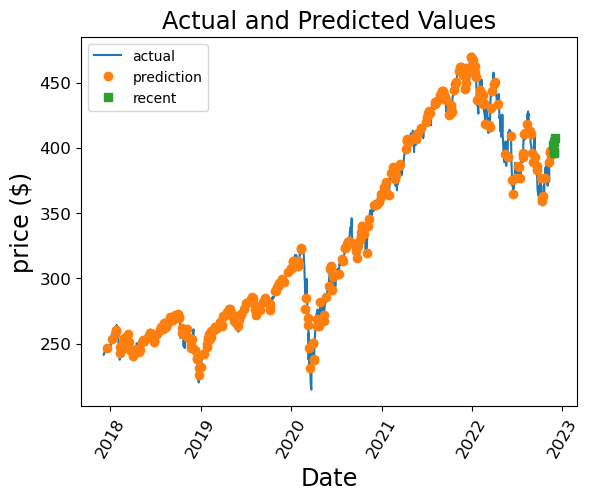

In [3]:
# initiating arrays for labels
labels = np.array(stock.SPY.Close[1:])
# can't use the data set we're training against in the predictors
features = stock.drop(('SPY', 'Close'), axis=1)[1:]
# grabbing headers of residual columns
feature_list = list(features.columns)

# splits the train and test sets
# this is just an example and the split is *not optimized* for correct sampling
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

# make a prediction
predictions = rf.predict(test_features)

# calculate mae
# there may be other, better loss functions
errors = abs(predictions - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'dollars.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
# TODO passing tuple to string is bad - fix
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


# recent date predictions
recent_predictions = rf.predict(stock.tail().drop(('SPY', 'Close'), axis=1))
df = stock.tail().copy()
df['predicted'] = recent_predictions

stock['diff'] = np.gradient(stock[('SPY', 'Close')])

# plotting predictions vs actuals
# this gives us some intuition on if we are directionally correct and accurate
predictions_data = pd.DataFrame({'date': test_features.index, 'prediction': predictions})

recent_predictions_data = pd.DataFrame({'date': df.index, 'prediction': recent_predictions})

actual_data = pd.DataFrame({'date': stock.index[1:], 'actuals': labels})

plt.plot(actual_data['date'], actual_data['actuals'], label = 'actual')

plt.plot(predictions_data['date'], predictions_data['prediction'], marker='o', linestyle='', label = 'prediction')

plt.plot(recent_predictions_data.date, recent_predictions_data.prediction, label='recent', linestyle='', marker='s')

plt.xticks(rotation = '60'); 
plt.legend()

plt.xlabel('Date', fontsize='xx-large'); 
plt.ylabel('price ($)', fontsize='xx-large'); 
plt.title('Actual and Predicted Values', fontsize='xx-large');
plt.tick_params('both', labelsize='large')
plt.show()

In [4]:
labels = np.array(stock.SPY.Close[1:])
features = stock['SPY'].drop('Close', axis=1)[1:]
feature_list = list(stock.columns)
feature_list.remove(('SPY', 'Close'))

In [5]:
features = stock.drop(('SPY', 'Close'), axis=1)[1:]

In [6]:
df

XLE                                               \
                 Open       High        Low      Close      Volume   
Date                                                                 
2022-11-25  92.269997  92.919998  91.709999  91.870003   7591300.0   
2022-11-28  89.620003  90.750000  89.050003  89.349998  29131200.0   
2022-11-29  90.339996  91.230003  90.010002  90.699997  19024200.0   
2022-11-30  91.709999  91.889999  89.720001  91.150002  21907500.0   
2022-12-01  91.790001  92.250000  90.540001  90.849998  18536792.0   

                   XLK                                                  ...  \
                  Open        High         Low       Close      Volume  ...   
Date                                                                    ...   
2022-11-25  133.470001  134.009995  133.210007  133.600006   1631500.0  ...   
2022-11-28  132.089996  132.940002  130.210007  130.740005   6515100.0  ...   
2022-11-29  130.570007  130.960007  128.929993  129.460007   5785100.0  ...   
2022-11-30  129.399994  135.979996  129.270004  135.960007  11656600.0  ...   
2022-12-01  136.089996  136.800003  134.639999  136.149994   7475479.0  ...   

                   QQQ                                             TLT  \
                  High         Low       Close      Volume        Open   
Date                                                                     
2022-11-25  287.910004  286.420013  286.920013  15498800.0  102.610001   
2022-11-28  286.959991  281.760010  282.709991  38714200.0  103.610001   
2022-11-29  283.350006  279.170013  280.570007  35618900.0  102.150002   
2022-11-30  293.470001  279.970001  293.359985  74387600.0  101.620003   
2022-12-01  295.750000  290.880005  293.720001  50763151.0  103.150002   

                                                             predicted  
                  High         Low       Close      Volume              
Date                                                                    
2022-11-25  102.930000  102.430000  102.900002   9486100.0  402.431739  
2022-11-28  103.809998  102.690002  103.190002  14563200.0  396.788413  
2022-11-29  102.959999  101.910004  101.980003  16576400.0  395.805290  
2022-11-30  102.730003  101.370003  102.730003  21561800.0  404.608859  
2022-12-01  105.809998  103.099998  105.760002  51752555.0  407.538643  

[5 rows x 36 columns]

In [7]:
labels_close = np.array(stock[('SPY', 'Close')])
labels_open = np.array(stock[('SPY', 'Open')])
labels_low = np.array(stock[('SPY', 'Low')])
labels_high = np.array(stock[('SPY', 'High')])
features = stock[1:stock.__len__()-1]
feature_list = list(features.columns)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels_close[2:], test_size = 0.2,
                                                                           random_state = 42)

# Instantiate model 
rf_close = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf_close.fit(train_features, train_labels)

predictions_close = rf_close.predict(test_features)

errors = abs(predictions_close - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'dollars.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# recent date predictions
recent_close_predictions = rf_close.predict(stock.tail())
df = stock.tail().copy()
df['tom close'] = recent_close_predictions
df['diff pred'] = recent_close_predictions - df[('SPY', 'Close')]



predictions_data = pd.DataFrame({'prediction': predictions_close}, index=test_features.index)
predictions_data.sort_index(inplace=True)

# indices = stock.index.get_loc(predictions_data.index.to_list())

actual_slice = stock.shift(1).loc[stock.index.isin(test_features.index)]

Mean Absolute Error: 2.41 dollars.
Accuracy: 99.24 %.


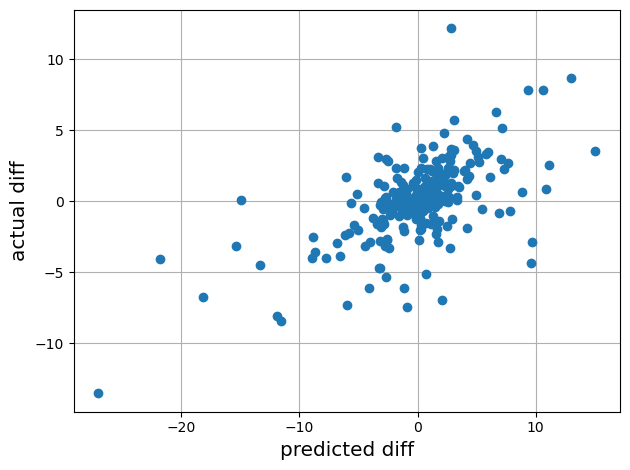

In [8]:
# TODO color plot and calculate direction accuracy
plt.plot(
    predictions_data['prediction']-actual_slice[('SPY', 'Close')], 
    actual_slice['diff'], 
    marker='o', 
    linestyle=''
)

plt.ylabel('actual diff', fontsize='x-large')
plt.xlabel('predicted diff', fontsize='x-large')

plt.grid(True)

plt.tight_layout()

plt.show()

In [9]:
predictions_data['prediction']-actual_slice[('SPY', 'Close')]

Date
2017-12-19   -0.924343
2018-01-09    0.841513
2018-01-18    0.565615
2018-01-22    2.040161
2018-01-23    0.765886
                ...   
2022-11-11    2.859945
2022-11-15    2.534433
2022-11-16   -1.683244
2022-11-18    2.699848
2022-11-23    1.296281
Length: 252, dtype: float64

In [10]:
actual_slice['diff']

Date
2017-12-19     0.304367
2018-01-09     0.516541
2018-01-18     1.000778
2018-01-22     1.637131
2018-01-23     1.328232
                ...    
2022-11-11    12.190002
2022-11-15    -0.010010
2022-11-16     0.165009
2022-11-18     0.289993
2022-11-23     3.915009
Name: diff, Length: 252, dtype: float64

In [11]:
predictions_data

,prediction
Date,
2017-12-19,246.449727
2018-01-09,253.491370
2018-01-18,258.463717
2018-01-22,260.676026
2018-01-23,261.504747
...,...
2022-11-11,397.549947
2022-11-15,397.654429
2022-11-16,396.806747


In [12]:
df

XLE                                               \
                 Open       High        Low      Close      Volume   
Date                                                                 
2022-11-25  92.269997  92.919998  91.709999  91.870003   7591300.0   
2022-11-28  89.620003  90.750000  89.050003  89.349998  29131200.0   
2022-11-29  90.339996  91.230003  90.010002  90.699997  19024200.0   
2022-11-30  91.709999  91.889999  89.720001  91.150002  21907500.0   
2022-12-01  91.790001  92.250000  90.540001  90.849998  18536792.0   

                   XLK                                                  ...  \
                  Open        High         Low       Close      Volume  ...   
Date                                                                    ...   
2022-11-25  133.470001  134.009995  133.210007  133.600006   1631500.0  ...   
2022-11-28  132.089996  132.940002  130.210007  130.740005   6515100.0  ...   
2022-11-29  130.570007  130.960007  128.929993  129.460007   5785100.0  ...   
2022-11-30  129.399994  135.979996  129.270004  135.960007  11656600.0  ...   
2022-12-01  136.089996  136.800003  134.639999  136.149994   7475479.0  ...   

                   QQQ                     TLT                          \
                 Close      Volume        Open        High         Low   
Date                                                                     
2022-11-25  286.920013  15498800.0  102.610001  102.930000  102.430000   
2022-11-28  282.709991  38714200.0  103.610001  103.809998  102.690002   
2022-11-29  280.570007  35618900.0  102.150002  102.959999  101.910004   
2022-11-30  293.359985  74387600.0  101.620003  102.730003  101.370003   
2022-12-01  293.720001  50763151.0  103.150002  105.809998  103.099998   

                                        diff   tom close diff pred  
                 Close      Volume                                  
Date                                                                
2022-11-25  102.900002   9486100.0 -3.255005  397.185083 -5.144904  
2022-11-28  103.190002  14563200.0 -3.549988  396.088825  0.178821  
2022-11-29  101.980003  16576400.0  5.884995  404.723347  9.493336  
2022-11-30  102.730003  21561800.0  6.074997  406.027909 -1.652084  
2022-12-01  105.760002  51752555.0 -0.299988  403.715315 -3.664690  

[5 rows x 38 columns]

In [13]:
x = df['diff pred'][-2]/df['SPY','Close'][-2]*100
y = df['diff pred'][-1]/df['SPY','Close'][-2]*100

print(df.index[-2].month, df.index[-2].day, f'{x*.66:.2f}%', f'{x:.2f}%', f'{x*1.33:.2f}%')
print(df.index[-1].month, df.index[-1].day, f'{y*.66:.2f}%', f'{y:.2f}%', f'{y*1.33:.2f}%')

11 30 -0.27% -0.41% -0.54%
12 1 -0.59% -0.90% -1.20%


In [14]:
# SPY RV vs SPY IV compared to SPY/VIX correlation

In [15]:
import pickle

In [16]:
with open('price_model.pkl', 'wb') as fn:
    pickle.dump(rf_close, fn)

In [17]:
with open('price_model.pkl', 'rb') as new_fn:
    a_new_object = pickle.load(new_fn)

In [18]:

# recent date predictions
recent_close_predictions = a_new_object.predict(stock.tail())

In [19]:
recent_close_predictions

array([397.18508255, 396.08882483, 404.72334656, 406.02790878,
       403.71531458])